In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Setup

In [2]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the infrenece time
import time

print(tf.__version__)
print(f"The following GPU devices are available: {tf.test.gpu_device_name()}")

2.15.0
The following GPU devices are available: /device:GPU:0


##Select and load model

* [ssd + mobilenet](https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/tensorFlow2/ssd-mobilenet-v2/1?tfhub-redirect=true) V2 small and fast.
* [FasterRCNN + InceptionResNet](https://www.kaggle.com/models/google/faster-rcnn-inception-resnet-v2/tensorFlow1/faster-rcnn-openimages-v4-inception-resnet-v2/1?tfhub-redirect=true) V2: high accuracy


In [3]:
# ssd mobilenet version 2
# module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

# inception resnet version 2
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

**Load Model**

In [4]:
model = hub.load(module_handle)

In [5]:
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction () -> Dict[['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)]] at 0x793AED13C280>}))

In [6]:
detector = model.signatures['default']

## download_and_resize_image

In [7]:
def display_image(image):
    """
    Displays an image inside the notebook.
    This is used by download_and_resize_image()
    """
    fig = plt.figure(figsize=(13, 8))
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    '''
    Fetches an image online, resizes it and saves it locally.

    Args:
        url (string) -- link to the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image

    Returns:
        (string) -- path to the saved image
    '''


    # create a temporary file ending with ".jpg"
    _, filename = tempfile.mkstemp(suffix=".jpg")

    # opens the given URL
    response = urlopen(url)

    # reads the image fetched from the URL
    image_data = response.read()

    # puts the image data in memory buffer
    image_data = BytesIO(image_data)

    # opens the image
    pil_image = Image.open(image_data)

    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)

    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")

    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)

    print("Image downloaded to %s." % filename)

    if display:
        display_image(pil_image)


    return filename

In [8]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

<ipython-input-7-d57a84f34562>:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to /tmp/tmplmqilmrr.jpg.


In [9]:
def draw_bounding_box_on_image(image,
                               y_min,
                               x_min,
                               y_max,
                               x_max,
                               color, font, thickness=4, display_str_list=()):
    """
    Adds a bounding box to an image.

    Args:
      image -- the image object.
      y_min, x_min, y_max, x_max -- bouding box coordinates.
      color -- color for the bounding box edges.
      font -- font for class label.
      thickness -- edge thickness of the bounding box.
      display_str_list -- class labels for each object detected.

    Returns:
      No return.
    """
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    # scale the bouding box coordinates to the height and width of the image
    (left, top, right, bottom) = (x_min * img_width, y_min * img_height,
                                  x_max * img_width, y_max * img_height)

    # define the four edges of the detection box
    draw.line([ (left, top), (left, bottom), (right, bottom), (right, top), (left, top) ], width=thickness, fill=color)

    # If the total height of the display string added to the top of the bounding
    # box exceeds the top of the image, stack the string below the bouding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

    # each display_str has a top and bottom margin of 0.05x.
    total_display_str_heights = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_heights:
      text_bottom = top
    else:
      text_bottom = top + total_display_str_heights

    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
      text_width, text_height = font.getsize(display_str)
      margin = np.ceil(0.05 * text_height)
      draw.rectangle([(left, text_bottom - text_height - 2* margin),
                      (left + text_width, text_bottom),
                      ],fill=color)
      draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)
      text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """
  Overlay labeled boxes on an image with formatted scores and label names.

  Args:
    image -- the image as a numpy array
    boxes -- list of detection boxes
    class_names -- list of classes for each detected object
    scores -- numbers showing the model's confidence in detecting that object
    max_boxes -- maximum detection boxes to overlay on the image (default is 10)
    min_score -- minimum score required to display a bounding box

  Returns:
    image -- the image after detection boxes and classes are overlaid on the ogirinal
    image
  """
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    # only display detection boxes that have the minimum score or higher
    if scores[i] >= min_score:
      y_min, x_min, y_max, x_max = tuple(boxes[i])
      display_str = "{}: {}".format(class_names[i].decode("ascii"),
                                    int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      # draw one bounding box and overlay the class labels onto the image
      draw_bounding_box_on_image(image_pil,
                                 y_min, x_min, y_max, x_max,
                                 color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))

  return image

**rnu_detector**

In [10]:
def load_img(path):
  """
  Loads a JPEG image and converts it to a tensor.

  Args:
    path (string) -- path to a locally saved JPEG image

  Returns:
    (tensor) -- an image tensor
  """
  # read the file
  img = tf.io.read_file(path)

  # convert to a tensor
  img = tf.image.decode_jpeg(img, channels=3)

  return img

def run_detector(detector, path):
  """
  Runs inference on a local file using an object detection model.

  Args:
    detector (model) -- an object detection model loaded from TF Hub.
    path (string) -- path to an image saved locally
  """
  # load an image tensor from a local file path
  img = load_img(path)

  # add a batch dimension in front of the tensor
  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  # run inference using the model
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  # save the results in a dictionary
  result = {key: value.numpy() for key, value in result.items()}

  # print results
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time - start_time)

  # draw predicted boxes over the image
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"]
  )

  # display the image
  display_image(image_with_boxes)

In [11]:
run_detector(detector, downloaded_image_path)

Found 100 objects.
Inference time:  58.79678916931152


<ipython-input-9-c121ec36c559>:34: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-9-c121ec36c559>:46: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


In [31]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

In [40]:
image_url_my = "https://www.privatephotoreview.com/wp-content/uploads/2024/03/01_MG_1128.jpg"

<ipython-input-7-d57a84f34562>:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to /tmp/tmprd6sau5r.jpg.
Found 100 objects.
Inference time:  1.218803882598877
Inference time: 3.024906635284424


<ipython-input-9-c121ec36c559>:34: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-9-c121ec36c559>:46: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


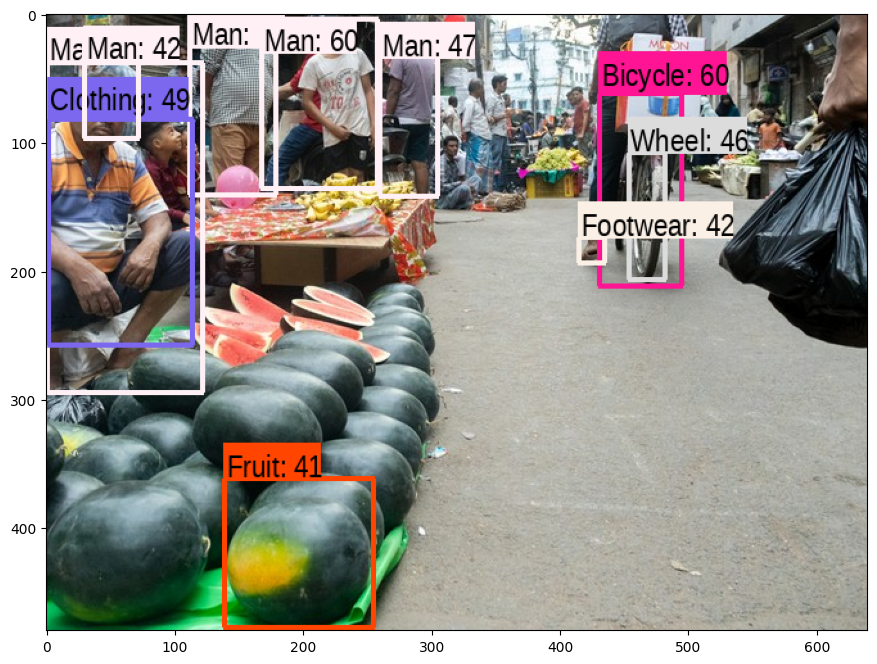

In [41]:
detect_img(image_url_my)

In [14]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.4 MB/s eta 0:00:00


In [24]:
def run_gradio_detector(detector, input_img):
  """
  Runs inference on a local file using an object detection model.

  Args:
    detector (model) -- an object detection model loaded from TF Hub.
    path (string) -- path to an image saved locally
  """

  # add a batch dimension in front of the tensor
  converted_img = tf.image.convert_image_dtype(input_img, tf.float32)[tf.newaxis, ...]

  # run inference using the model
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  # save the results in a dictionary
  result = {key: value.numpy() for key, value in result.items()}

  # print results
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time - start_time)

  # draw predicted boxes over the image
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"]
  )

  # display the image
  display_image(image_with_boxes)

In [ ]:
import gradio as gr
import time
import requests
from PIL import Image
from io import BytesIO

def resize_img(input_image, new_width=256, new_height=256):

    # Open the image file
    # image = Image.open(input_image)
    # Resize the image with anti-aliasing filter
    resized_image = input_image.resize((new_width, new_height), Image.ANTIALIAS)
    return resized_image

# Define the function to detect image
def detect_img(input_image):
    start_time = time.time()
    image_path = resize_img(input_image, 640, 480)
    output_image = run_gradio_detector(detector, image_path)
    end_time = time.time()
    inference_time = end_time - start_time
    return output_image, f"Inference time: {inference_time:.2f} seconds"

# Define Gradio interface
image_input = gr.Image(label="Input Image")
image_output = gr.Image(label="Output Image")
output_text = gr.Textbox(label="Inference Time")

# Create interface
gr.Interface(
    fn=detect_img,
    inputs=image_input,
    outputs=[image_output, output_text],
    title="Image Detection",
    description="Upload an image to detect and see the processed image along with inference time."
).launch(debug=True)
